To change the pwd to the root directory of the repository so we can access the code directly by relatively referencing src and not needing to install sequence. 

In [1]:
cd ../..

/home/asingal/home/quisp/SeQUeNCe


/home/asingal/home/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Objective

The purpose of this notebook is to study the variation of time taken to generate 1000 entanglements in a Meet-in-the-Middle quantum repeater configurations against a varying number of memories in the end nodes and Bell state measurement apparatus. 

In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from datetime import date, datetime

from src.topology.router_net_topo import RouterNetTopo
from src.app.request_app import RequestApp
import src.utils.log as log

In [3]:
today = date.today()

CONFIG_FILE = "example/SC24/config_files/simple_link.json"

# meta params
NO_TRIALS = 10
LOGGING = False
LOG_OUTPUT = "example/SC24/exp_1_log.txt"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app"]

## Simulation paremeters

We consider the two communicating nodes to be 20 km apart from each other and the BSM is placed right in the middle of the two end nodes. The fibers have an attenuation of .2 dB/Km and the detectors are perfect threshold detectors. 

In [4]:
# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(3e12)  # 10 seconds

# qc params
QC_FREQ = 1e11

# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memories = [1,2,4,8,16,32,64]  # iterate through these

# storing data
data_dict = {"Memory Count": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average TTT": [],
             "Std. TTT":[],
             }

## Main simulation script

In [5]:
collect_time_base = COLLECT_TIME

for i, num_memo in enumerate(num_memories):
    print(f"Running {NO_TRIALS} trials for memory count {num_memo} ({i + 1}/{len(num_memories)})")
    data_dict["Memory Count"].append(num_memo)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)

    COLLECT_TIME = collect_time_base/num_memo

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        if LOGGING:
            # set log
            if num_memo == num_memories[0]:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif num_memo == num_memories[1]:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        # Random seed for performing the simulations
        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(int(datetime.now().timestamp()) + j + (trial_no * 3))

        # set quantum channel parameters
        for qc in net_topo.get_qchannels():
            qc.frequency = QC_FREQ

        # establish "left" node as the start node. 
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        # Checking to see if the start node was established or not
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        
        # Setting the "right" node as the 'end' node
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        # Checking to see if the end node was established or not
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        # Establishing the apps on the start and end nodes. 
        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        # initialize and start app
        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1.0)
        tl.run()

        # # Used for debugging
        # attempt = app_start.node.total_attempts
        # success = app_start.node.succesful_attempts
        # prob = success/attempt

        throughputs[trial_no] = app_start.get_throughput()        
        time_to_thousand[trial_no] = app_start.node.time_to_thousand
        

        print(f"\tCompleted trial {trial_no + 1}/{NO_TRIALS}")



    print("Finished trials.")

    # Saving the results in a dictionary to later convert into a Pandas data frame to plot. 

    avg_throughput = np.mean(throughputs)
    std_throughput = np.std(throughputs)
    avg_TTT = np.mean(time_to_thousand)*1e-12
    std_TTT = np.std(time_to_thousand)*1e-12
    
    # # Used for debugging
    # print(f"Average throughput: {avg_throughput} +/- {std_throughput}")
    # print(f"time to thousand entanglements:", time_to_thousand)

    data_dict["Average Throughput"].append(avg_throughput)
    data_dict["Std. Throughput"].append(std_throughput)
    data_dict["Average TTT"].append(avg_TTT)
    data_dict["Std. TTT"].append(std_TTT)
             

df = pd.DataFrame(data_dict)

Running 10 trials for memory count 1 (1/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Completed trial 6/10
	Completed trial 7/10
	Completed trial 8/10
	Completed trial 9/10
	Completed trial 10/10
Finished trials.
Running 10 trials for memory count 2 (2/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Completed trial 6/10
	Completed trial 7/10
	Completed trial 8/10
	Completed trial 9/10
	Completed trial 10/10
Finished trials.
Running 10 trials for memory count 4 (3/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Completed trial 6/10
	Completed trial 7/10
	Completed trial 8/10
	Completed trial 9/10
	Completed trial 10/10
Finished trials.
Running 10 trials for memory count 8 (4/7)
	Completed trial 1/10
	Completed trial 2/10
	Completed trial 3/10
	Completed trial 4/10
	Completed trial 5/10
	Com

## Results

We see that the amount of time taken to generate 1000 entanglements decreases linearly (Note we are increasing the number of memories exponentially) as we increase the number of available memories which aligns well with theoretical expectations. 

,Memory Count,Average Throughput,Std. Throughput,Average TTT,Std. TTT
0,1,492.833333,9.040956,2.01816,0.041205
1,2,999.333333,19.136933,0.99844,0.025352
2,4,1983.200000,23.927297,0.50620,0.008495
3,8,3953.333333,100.814461,0.25364,0.008138
4,16,7853.866667,144.082939,0.12788,0.003057
5,32,15794.133333,277.868202,0.06392,0.001568
6,64,31776.000000,974.643867,0.03136,0.001015


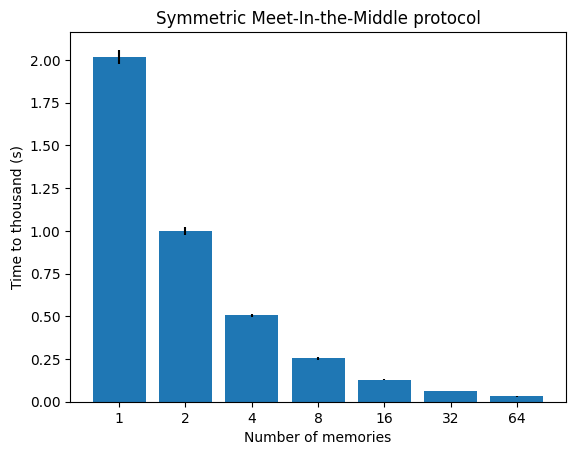

In [6]:
plt.bar(range(len(df["Average TTT"])), df["Average TTT"], yerr = df["Std. TTT"], tick_label = df["Memory Count"])
plt.ylabel("Time to thousand (s)")
plt.xlabel("Number of memories")
plt.title("Symmetric Meet-In-the-Middle protocol")
df